# Fastdup Tutorial

[Visit our GitHub Project Page](https://github.com/visualdatabase/fastdup)

## Install fastdup

In [74]:
!pip install -U fastdup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 39.2 MB 1.3 MB/s 
  Attempting uninstall: fastdup
    Found existing installation: fastdup 0.69
    Uninstalling fastdup-0.69:
      Successfully uninstalled fastdup-0.69


In [59]:
import fastdup

In [60]:
fastdup.__version__

'0.69'

## Download the food-101 dataset

In [61]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2022-06-12 04:44:16--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2022-06-12 04:44:17--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz.1’

food-101.tar.gz.1   100%[===================>]   4.65G  27.3MB/s    in 3m 6s   

2022-06-12 04:47:23 (25.7 MB/s) - ‘food-101.tar.gz.1’ saved [4996278331/4996278331]



In [62]:
!tar xzf food-101.tar.gz

## Run fastdup to gain insights from your data

In [63]:
fastdup.run('food-101')

Going to loop over dir food-101
Found total 101000 images to run on
[■                                                 ] 1% Estimated: 0 Minutes
Wrote  total of 101000 features, found 0 bad images
Found total 101000 images to run on
191) Finished write_index() faiss
Stored faiss index file ./faiss.index
1655010504 : INFO:     (add_vertices:460): Num vertices for group 0: 101000
1655010504 : INFO:     (commit_edge_buffer:609): In commit edge buffer (0,0)
1655010504 : INFO:     (commit_edge_buffer:680): Shuffling edges ...
1655010504 : INFO:     (commit_edge_buffer:688): Done shuffling edges in 0.011602 secs
1655010504 : INFO:     (commit_edge_buffer:692): Aggregating unique vertices...
1655010504 : INFO:     (commit_edge_buffer:705): Done aggregating unique vertex in 0.005672 secs
1655010504 : INFO:     (commit_edge_buffer:713): Combine vertex data
1655010504 : INFO:     (commit_edge_buffer:779): Done phase 2 in 0.027796 secs
1655010504 : INFO:     (commit_edge_buffer:787): Rename id co

In [64]:
fastdup.create_duplicates_gallery('similarity.csv',save_path='.', num_images=20)

100%|██████████| 20/20 [00:00<00:00, 51.70it/s]


Stored similarity visual view in  ./similarity.html



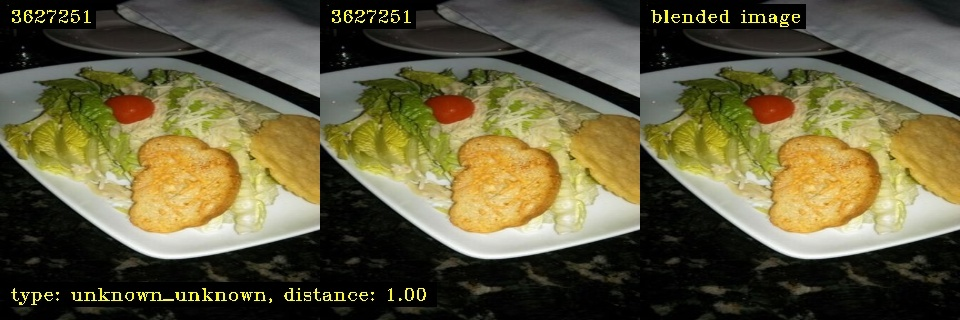
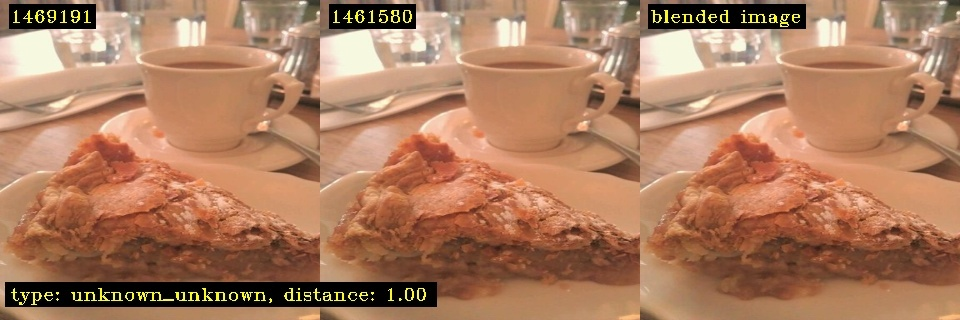
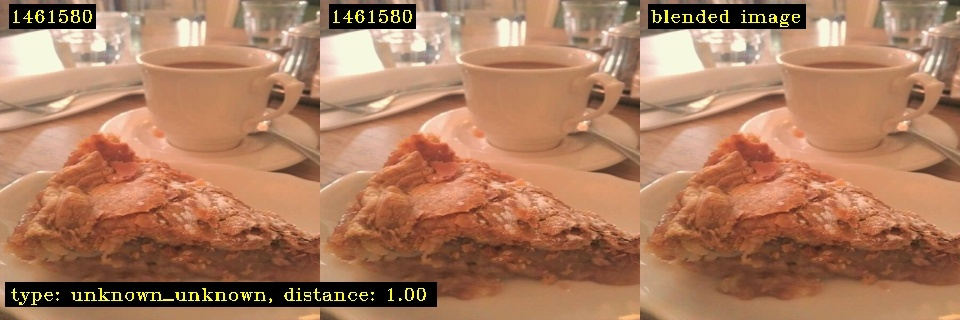
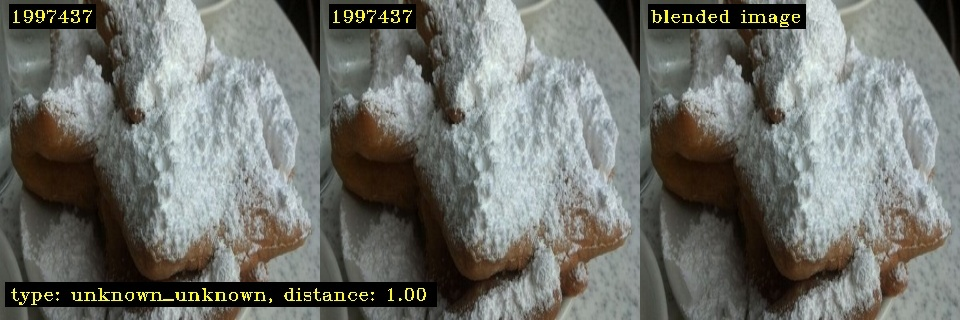
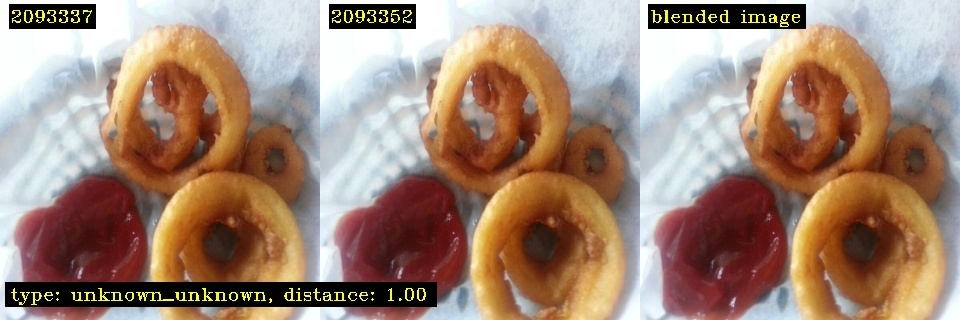
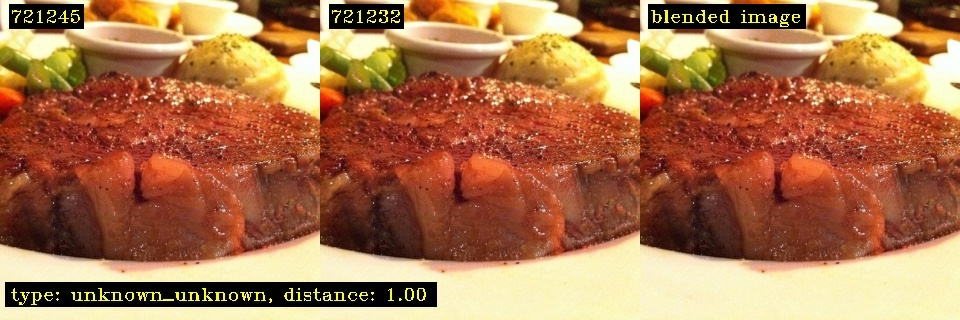
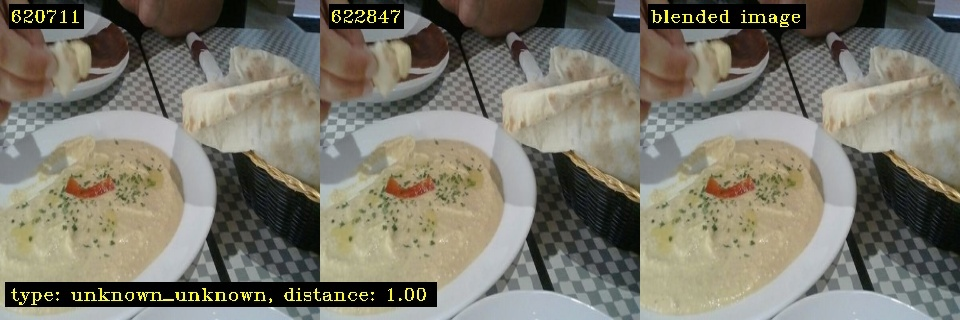
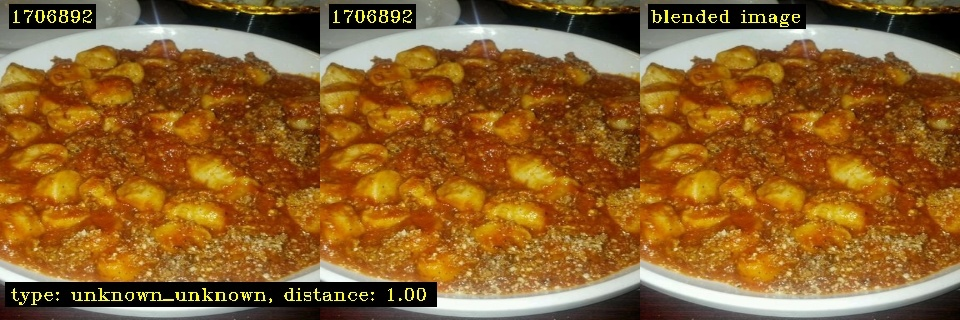
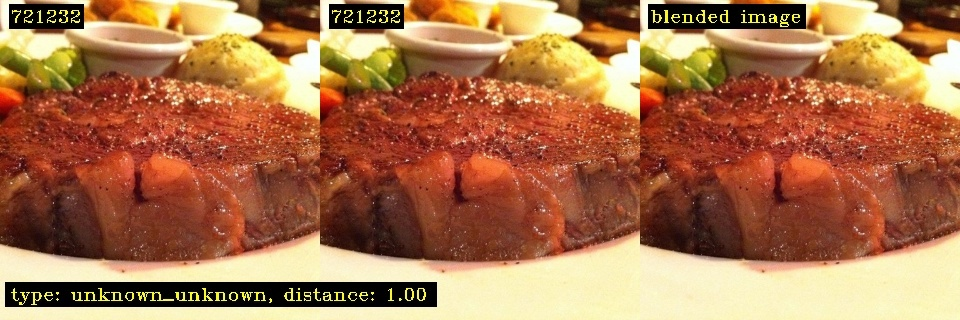
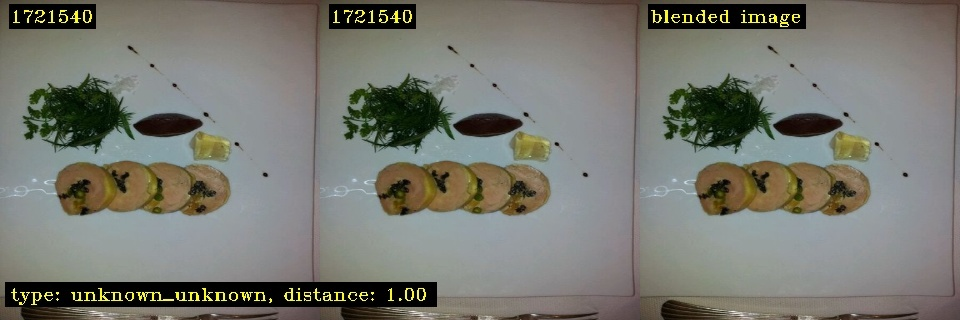
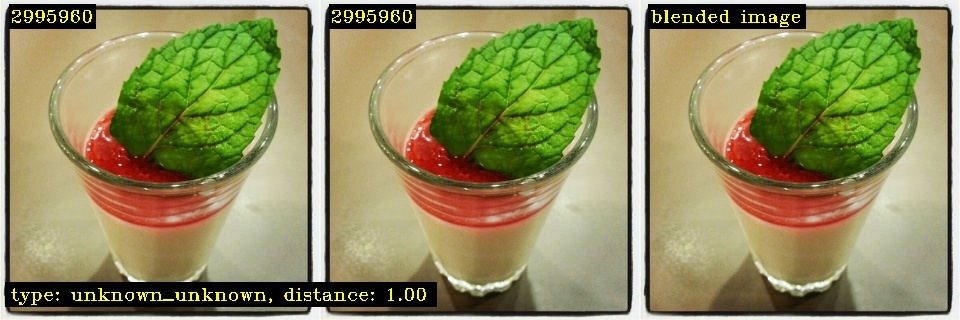
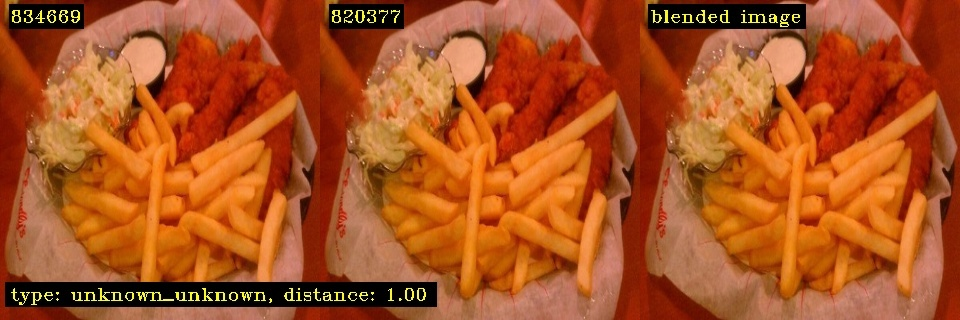
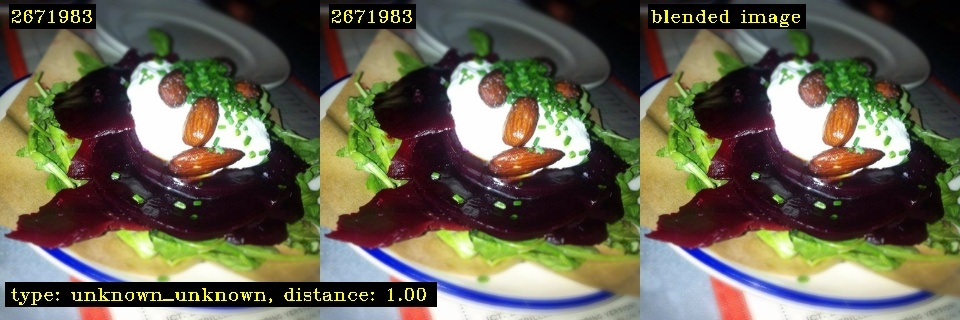
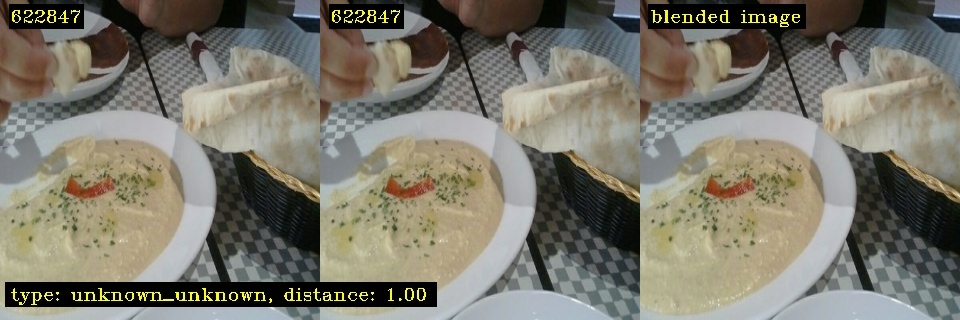
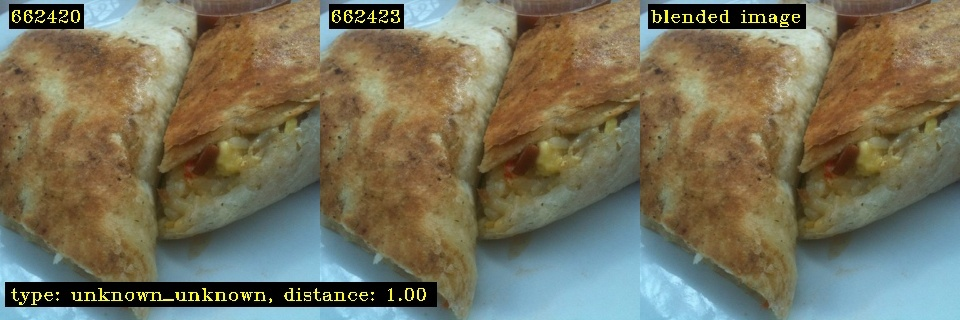
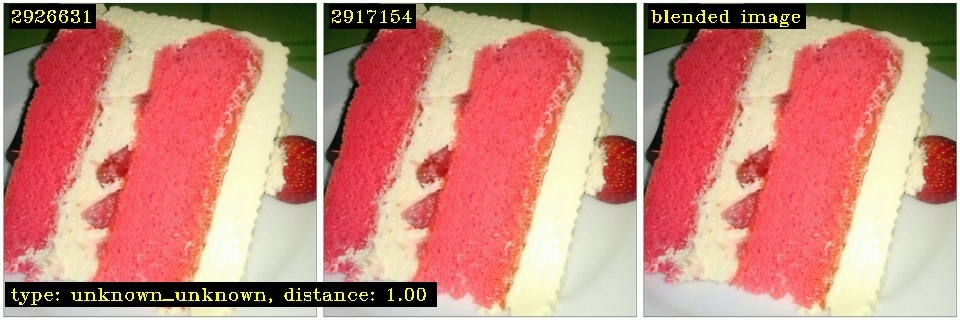
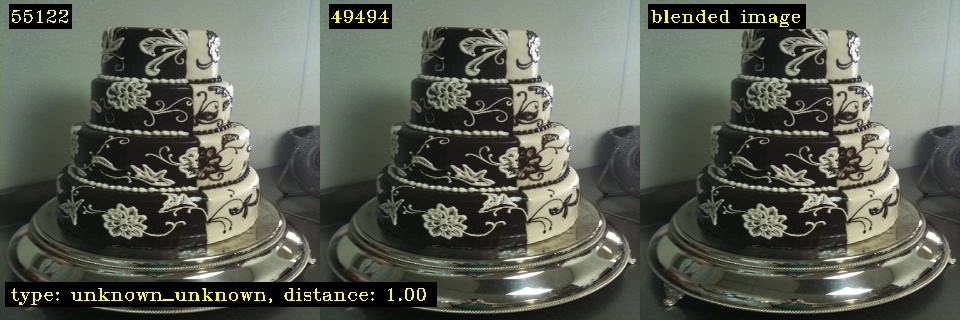
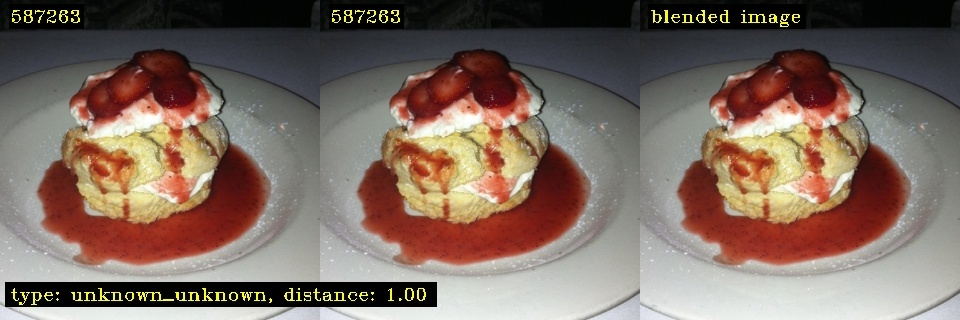
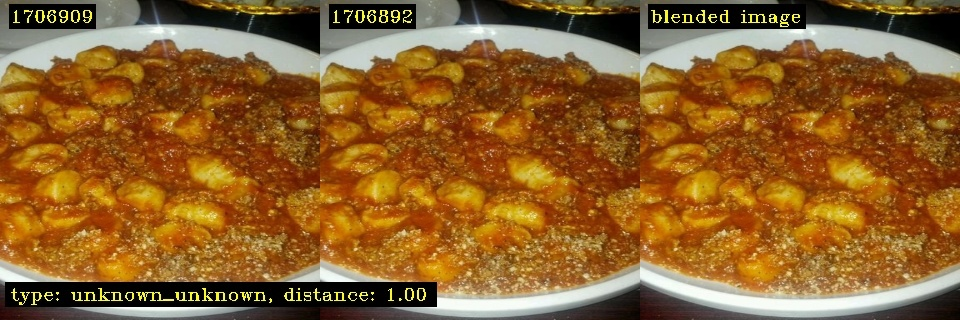
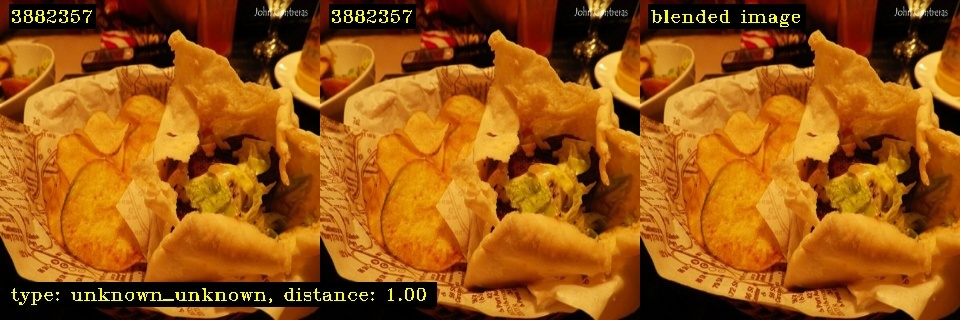

In [65]:
from IPython.display import HTML
HTML('similarity.html')

In [66]:
fastdup.create_outliers_gallery('outliers.csv',save_path='.', num_images=20)

100%|██████████| 20/20 [00:00<00:00, 84.93it/s]


Stored outliers visual view in  ./outliers.html



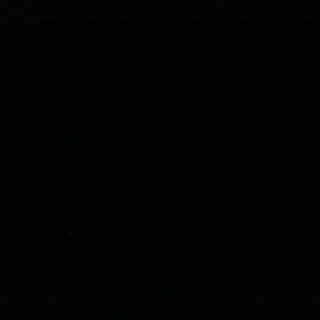
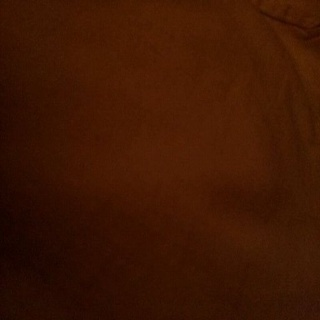
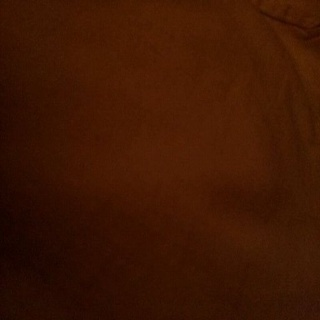
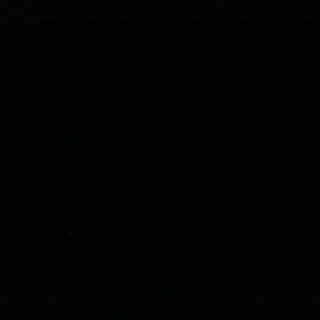
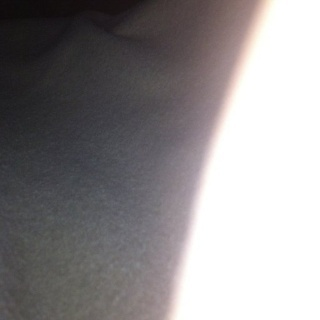
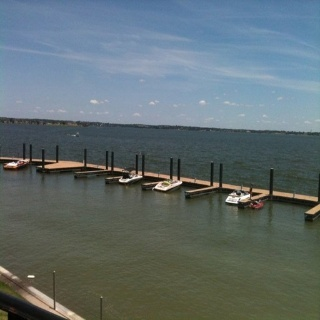
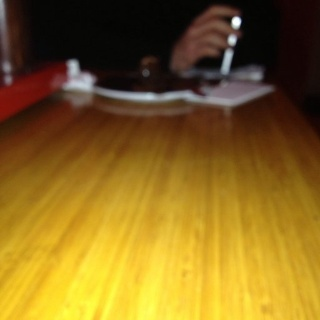
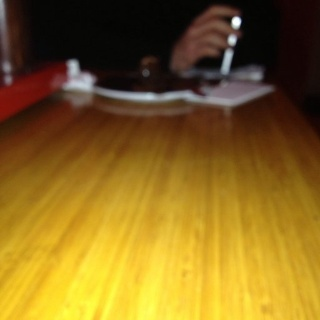
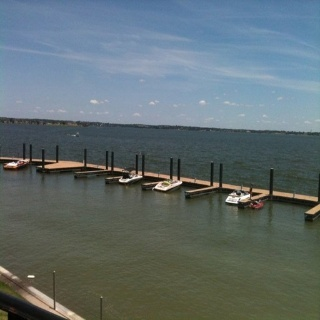
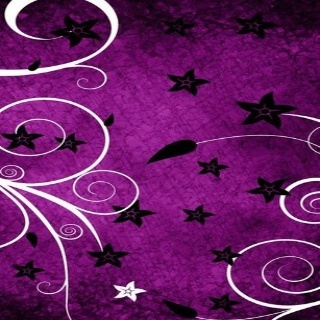
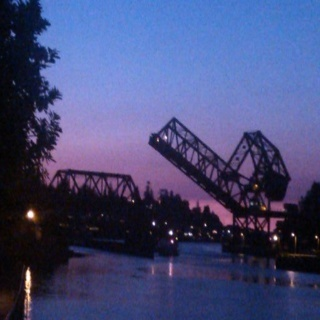
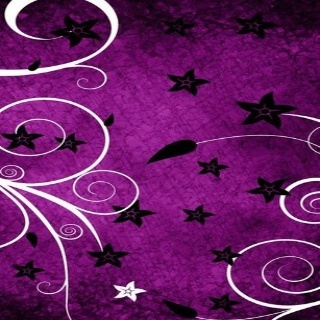
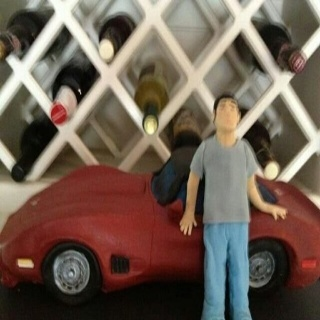
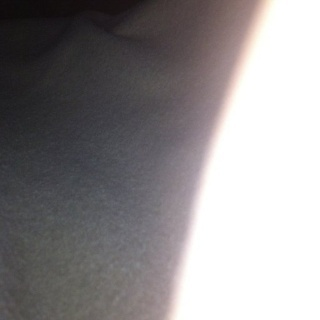
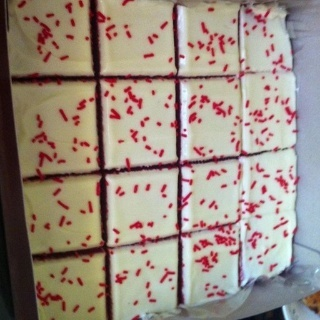
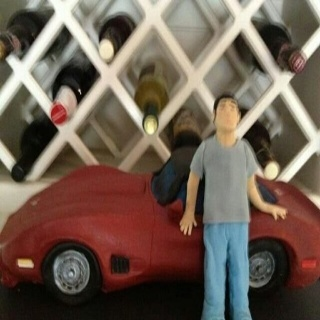
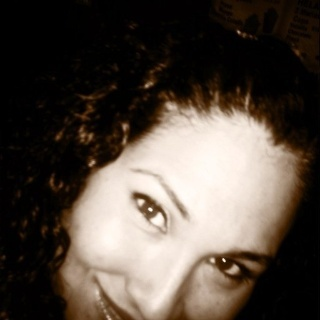
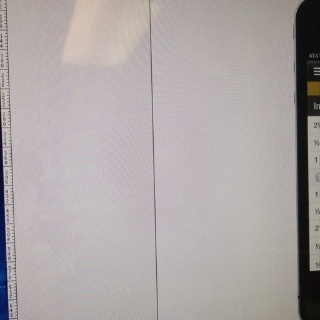
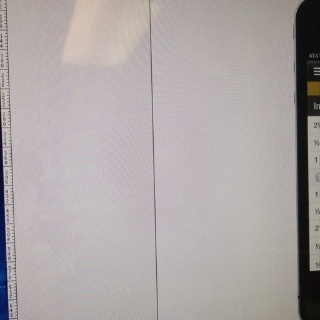
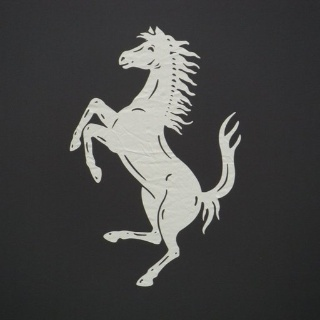

In [67]:
HTML('outliers.html')

## Perform graph analytics to find connected components of images

Connected components are clusters of similar images. In the code below we find the largest clusters of duplicate images and visualize them.

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from IPython.display import Image
import traceback
from tqdm import tqdm

In [4]:

NUM_COMPONENTS_TO_PLOT = 5
MAX_IMAGES_IN_GRID = 48

top_components = fastdup.find_top_components(work_dir='.')

# iterate over the top components
for index,(i,row) in tqdm(enumerate(top_components.head(NUM_COMPONENTS_TO_PLOT).iterrows()), 
                          total=NUM_COMPONENTS_TO_PLOT):
    try:
        # find the component id
        component_id = row['component_id']
        # find all the image filenames linked to this id
        files = row['files'][:MAX_IMAGES_IN_GRID]

        fig = plt.figure(figsize=(10,8))
        images = []
        for f in files:
            img = PILImage.open(f).convert('RGB').resize((300,300))
            transform = transforms.Compose([transforms.PILToTensor()])
            tensor = transform(img)
            images.append(tensor)

        # make a grid image of all components
        grid = make_grid(images, nrow=12, padding=3)
        plt.imshow(np.transpose(grid, (1, 2, 0)), interpolation='nearest')
     
        # plot the image
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        plt.title('Components ' + str(i) + "\n" + str([os.path.basename(x) for x in files]))
        plt.savefig('component' + str(index) + '.png', bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)
        plt.clf() 
        
    except Exception as ex:
        print('Failed on component', i, ex)
        traceback.print_exc()
    

100%|██████████| 5/5 [00:01<00:00,  4.65it/s]


<Figure size 432x288 with 0 Axes>

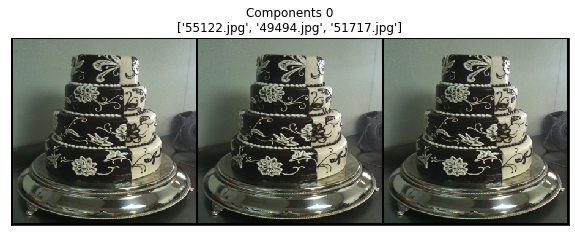

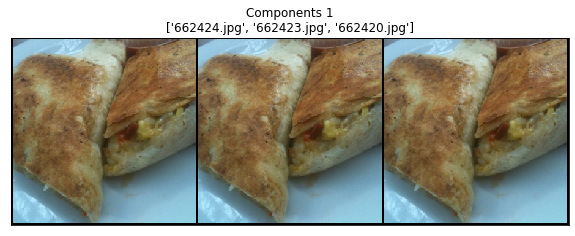

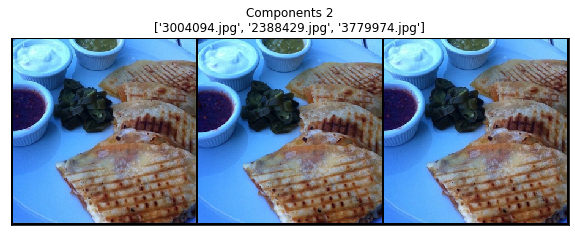

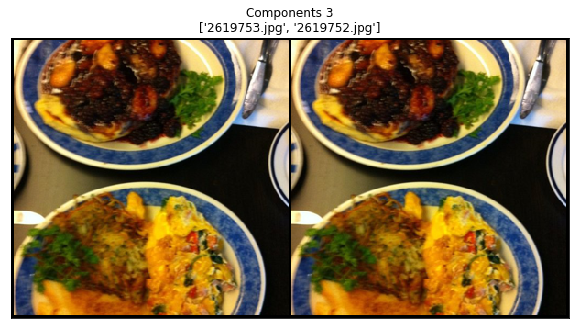

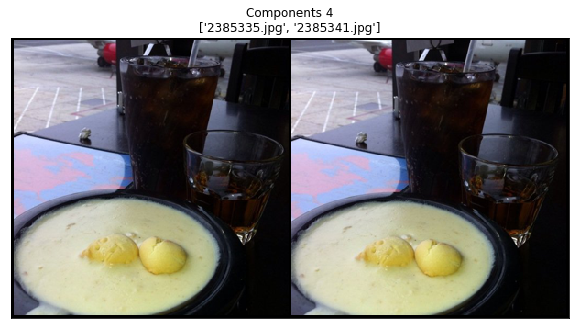

In [5]:
# displaay top components
for i in range(NUM_COMPONENTS_TO_PLOT):
  display(Image(filename=f'component{i}.png'))

## Delete duplicate images automatically

In [6]:
top_to_delete = list(top_components['component_id'].values[:5])
print("Going to delete top components")
fastdup.delete_components(top_components, top_to_delete, fastdup.LEAVE_ONE, True)

Going to delete top components


100%|██████████| 5/5 [00:00<00:00, 336.06it/s]

rm -f food-101/images/chocolate_cake/49494.jpg
rm -f food-101/images/chocolate_cake/51717.jpg
rm -f food-101/images/breakfast_burrito/662423.jpg
rm -f food-101/images/breakfast_burrito/662420.jpg
rm -f food-101/images/chicken_quesadilla/2388429.jpg
rm -f food-101/images/chicken_quesadilla/3779974.jpg
rm -f food-101/images/pancakes/2619752.jpg
rm -f food-101/images/clam_chowder/2385341.jpg
